# Income Prediction Model

This notebook demonstrates our **own logistic regression implementation**

## Dataset

**Source:** Adult Income Dataset (Census Bureau)
https://www.kaggle.com/datasets/mastmustu/income

**Problem:** Predict whether a person earns >$50K/year based on demographic and work-related features

**Dataset statistics:**
- **Total samples:** 43957 (after train/val split from original 32,561)
- **Training set:** 35165 samples (80%)
- **Validation set:** 8792 samples (20%)

**Class distribution:**
- **≤$50K:** ~76% (majority class - imbalanced)
- **>$50K:** ~24% (minority class)

**Features (13 total):**
- **Numeric (5):** age, educational-num, capital-gain, capital-loss, hours-per-week
- **Categorical (8):** workclass, education, marital-status, occupation, relationship, race, gender, native-country

**Target variable:** `income_>50K` (binary: 0 = ≤50K, 1 = >50K)

**Challenge:** Class imbalance makes this problem harder - the model could achieve 75% accuracy by always predicting ≤50K!

In [70]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import load_model

plt.style.use('default')
sns.set_palette("husl")

## 1. Load data and model

We use pre-split data to ensure reproducibility and fair evaluation.

In [71]:
# Load data
train_df = pd.read_csv('../data/train_split.csv')
val_df = pd.read_csv('../data/val_split.csv')

X_train = train_df.drop(columns=["income_>50K"])
y_train = train_df["income_>50K"]

X_val = val_df.drop(columns=["income_>50K"])
y_val = val_df["income_>50K"]

# Load trained model
model = load_model()

# Make predictions
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

X_val_processed = preprocessor.transform(X_val)
y_pred = logreg.predict(X_val_processed)

## 2. Logistic regression

Our implementation uses gradient descent. The following graph shows the cross-entropy loss and the hyperparameter learning rate over the number of iterations

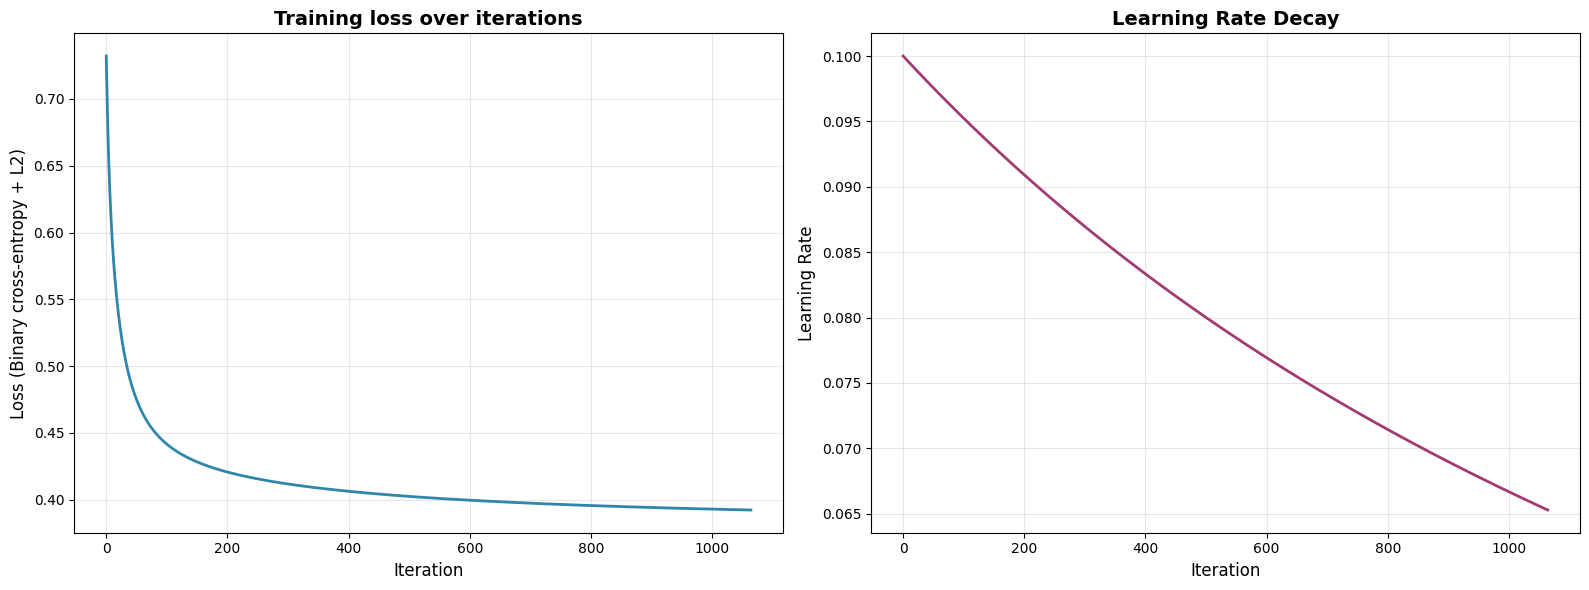

Initial loss: 0.7321
Final loss: 0.3923
Total iterations: 1065
Loss reduction: 46.41%


In [72]:
# Plot training loss curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax1.plot(logreg.losses, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss (Binary cross-entropy + L2)', fontsize=12)
ax1.set_title('Training loss over iterations', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Learning rate decay curve (if available)
if hasattr(logreg, 'initial_lr') and hasattr(logreg, 'lr_decay'):
    iterations = range(len(logreg.losses))
    learning_rates = [logreg.initial_lr / (1 + logreg.lr_decay * i) for i in iterations]
    ax2.plot(learning_rates, linewidth=2, color='#A23B72')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Decay', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
else:
    # Model was trained with old version - show info message
    ax2.text(0.5, 0.5, 'Learning rate decay not available\n(retrain model to see this plot)', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Learning rate decay', fontsize=14, fontweight='bold')
    ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Initial loss: {logreg.losses[0]:.4f}")
print(f"Final loss: {logreg.losses[-1]:.4f}")
print(f"Total iterations: {len(logreg.losses)}")
print(f"Loss reduction: {((logreg.losses[0] - logreg.losses[-1]) / logreg.losses[0] * 100):.2f}%")

# Check if model needs retraining
if not hasattr(logreg, 'initial_lr'):
    print("\n⚠️  Model was trained with old version. Retrain to see improvements:")
    print("   cd ../src && python train_model.py")

## 3. Model Performance Metrics

In [73]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred)
}

# Create metrics dataframe for visualization
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
metrics_df

,Metric,Score
0,Accuracy,0.824500
1,Precision,0.604703
2,Recall,0.769962
3,F1 Score,0.677399


## 4. Confusion matrix

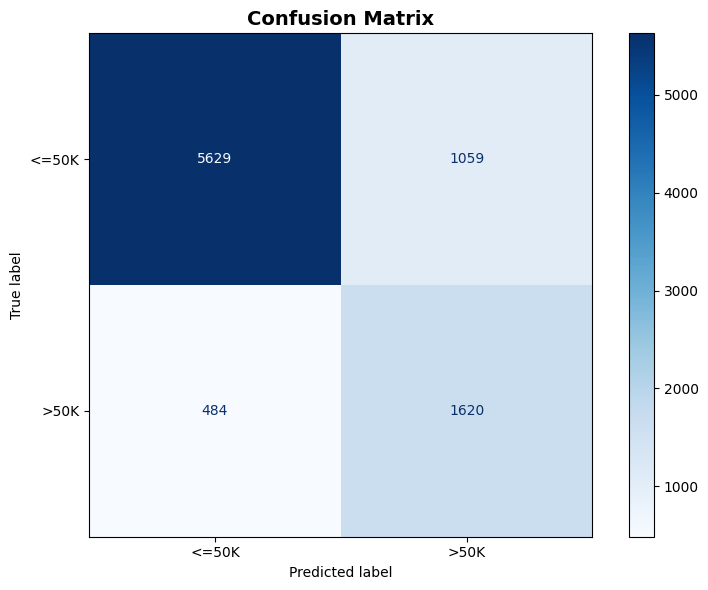


True negatives:   5629
False positives:  1059
False negatives:   484
True positives:   1620


In [74]:
cm = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue negatives:  {cm[0][0]:5d}")
print(f"False positives: {cm[0][1]:5d}")
print(f"False negatives: {cm[1][0]:5d}")
print(f"True positives:  {cm[1][1]:5d}")

## 5. Classification

In [75]:
print(classification_report(y_val, y_pred, target_names=['<=50K', '>50K']))

              precision    recall  f1-score   support

       <=50K       0.92      0.84      0.88      6688
        >50K       0.60      0.77      0.68      2104

    accuracy                           0.82      8792
   macro avg       0.76      0.81      0.78      8792
weighted avg       0.85      0.82      0.83      8792



## 6. Metrics

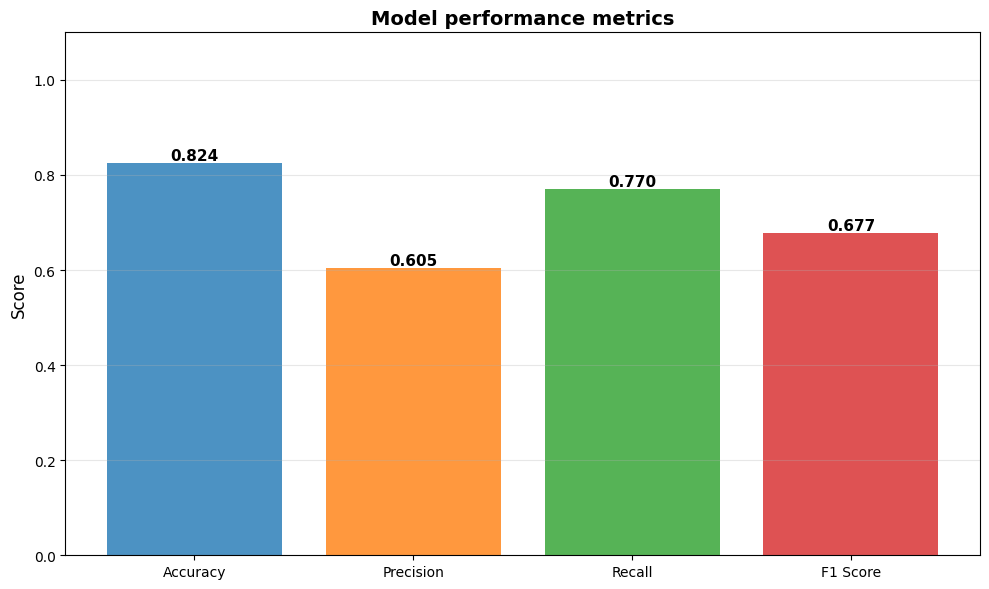

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

bars = ax.bar(metric_names, metric_values, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
              alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.3f}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model performance metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Feature weights
- **Green bars**: Features that increase P(income > 50K)
- **Red bars**: Features that decrease P(income > 50K)
- Weight magnitude indicates feature importance

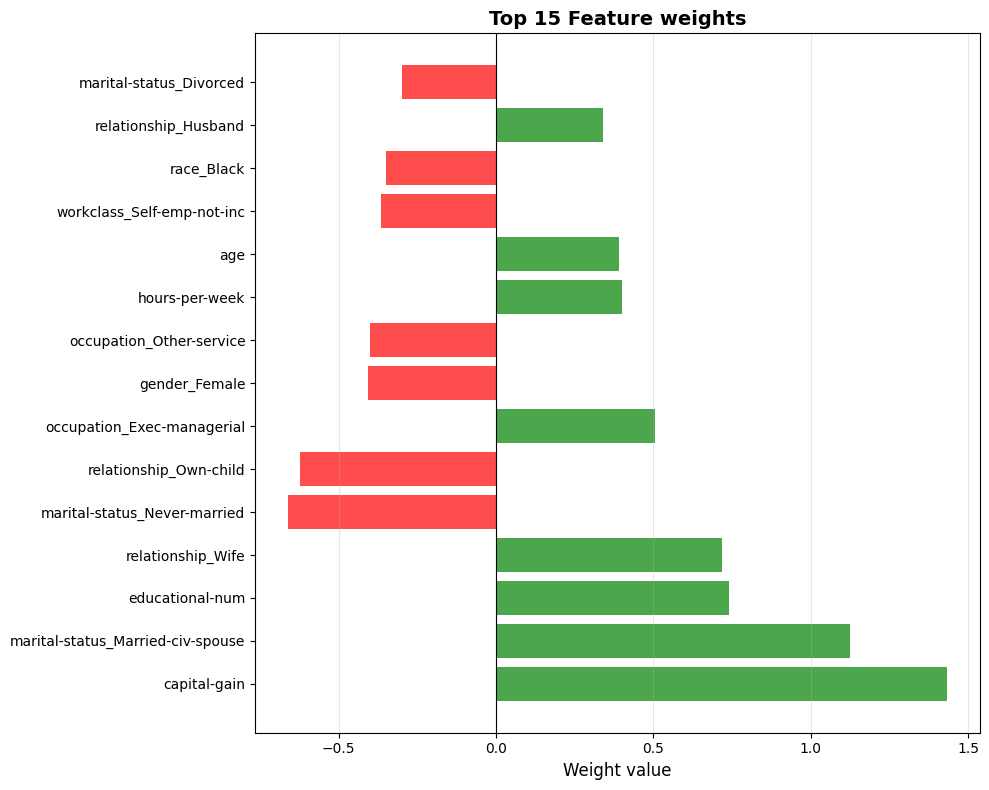

In [77]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_features['Weight']]

ax.barh(range(len(top_features)), top_features['Weight'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Weight value', fontsize=12)
ax.set_title(f'Top {top_n} Feature weights', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Sigmoid function

The sigmoid function σ(z) = 1/(1 + e^(-z)) transforms linear predictions into probabilities.
Let's visualize both the mathematical function and how our model's predictions are distributed.

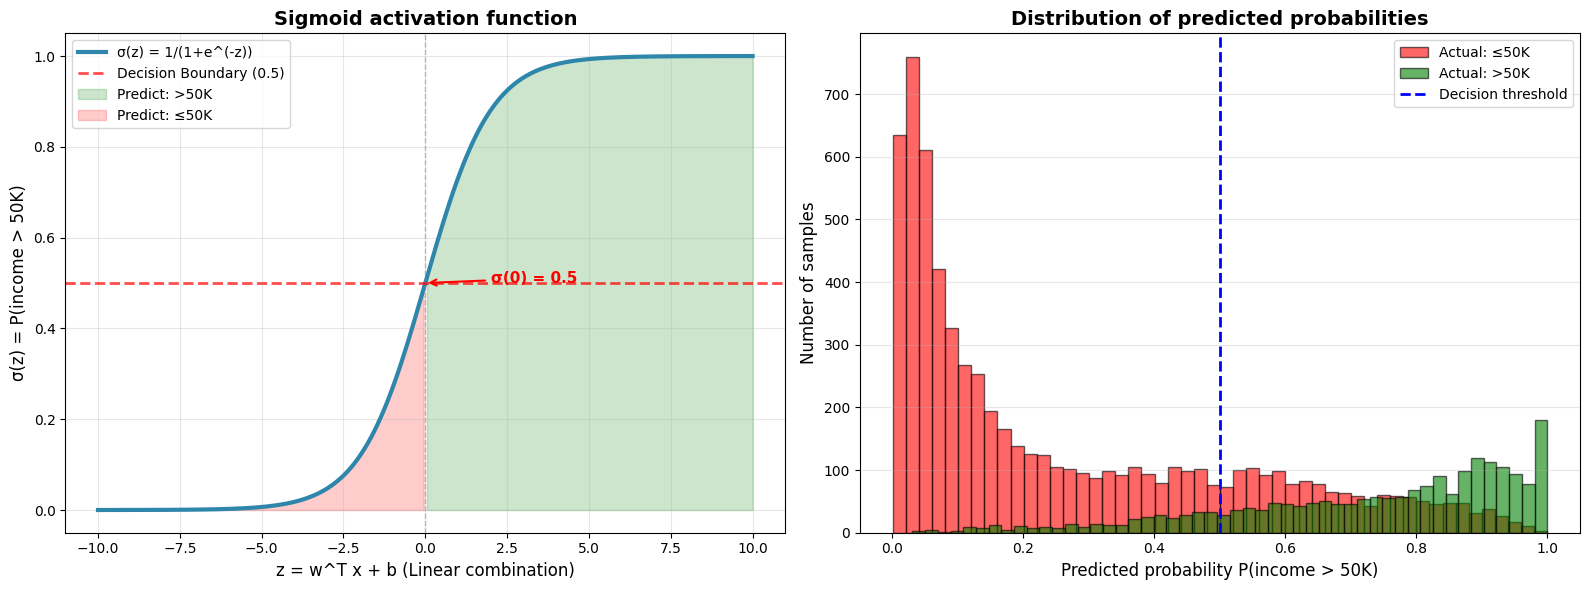


For actual ≤50K samples:
  Mean probability: 0.2631
  Median probability: 0.1477
  Std deviation: 0.2590

For actual >50K samples:
  Mean probability: 0.7358
  Median probability: 0.7949
  Std deviation: 0.2168


In [78]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

z_range = np.linspace(-10, 10, 200)
sigmoid_values = logreg.sigmoid(z_range)

ax1.plot(z_range, sigmoid_values, linewidth=3, color='#2E86AB', label='σ(z) = 1/(1+e^(-z))')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Decision Boundary (0.5)')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values >= 0.5), 
                  alpha=0.2, color='green', label='Predict: >50K')
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values < 0.5), 
                  alpha=0.2, color='red', label='Predict: ≤50K')

ax1.set_xlabel('z = w^T x + b (Linear combination)', fontsize=12)
ax1.set_ylabel('σ(z) = P(income > 50K)', fontsize=12)
ax1.set_title('Sigmoid activation function', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_ylim([-0.05, 1.05])

ax1.annotate('σ(0) = 0.5', xy=(0, 0.5), xytext=(2, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=11, color='red', fontweight='bold')

y_proba = logreg.predict_proba(X_val_processed)[:, 1]

proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax2.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Actual: ≤50K', edgecolor='black')
ax2.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Actual: >50K', edgecolor='black')
ax2.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision threshold')

ax2.set_xlabel('Predicted probability P(income > 50K)', fontsize=12)
ax2.set_ylabel('Number of samples', fontsize=12)
ax2.set_title('Distribution of predicted probabilities', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nFor actual ≤50K samples:")
print(f"  Mean probability: {proba_class0.mean():.4f}")
print(f"  Median probability: {np.median(proba_class0):.4f}")
print(f"  Std deviation: {proba_class0.std():.4f}")

print(f"\nFor actual >50K samples:")
print(f"  Mean probability: {proba_class1.mean():.4f}")
print(f"  Median probability: {np.median(proba_class1):.4f}")
print(f"  Std deviation: {proba_class1.std():.4f}")


## 10. Threshold optimization

The default threshold of 0.5 may not be optimal for imbalanced datasets.
Let's find the best threshold to maximize F1 score.

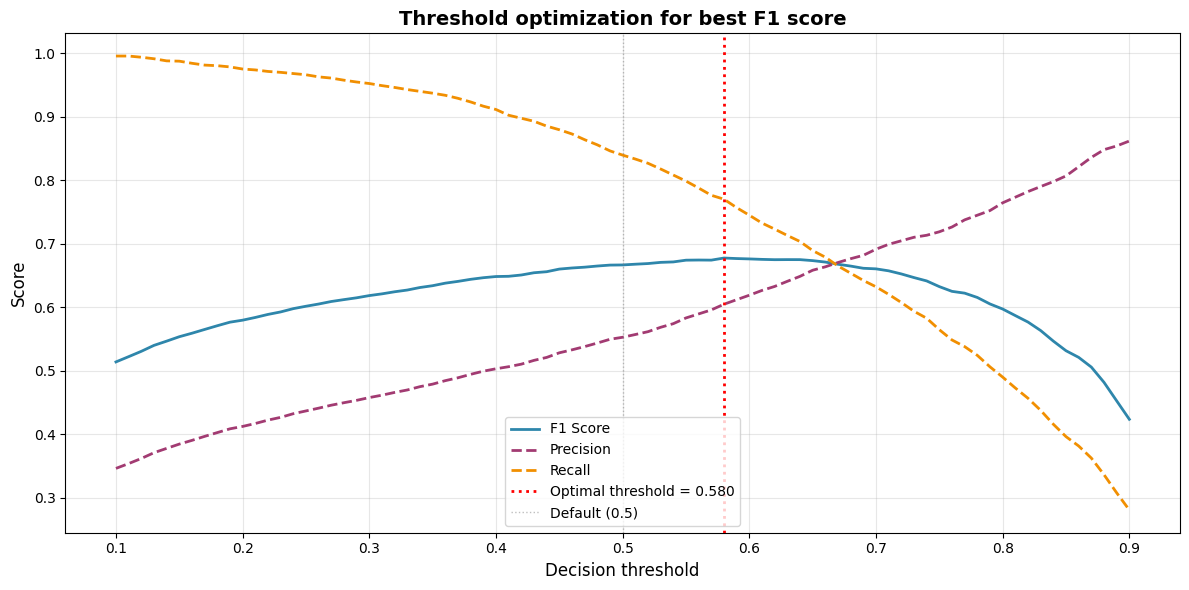


Optimal threshold: 0.580
Max F1 score: 0.6774

At optimal threshold:
  Precision: 0.6047
  Recall:    0.7700


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 81)
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))
    precision_scores.append(precision_score(y_val, y_pred_thresh))
    recall_scores.append(recall_score(y_val, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, linewidth=2, label='F1 Score', color='#2E86AB')
ax.plot(thresholds, precision_scores, linewidth=2, label='Precision', color='#A23B72', linestyle='--')
ax.plot(thresholds, recall_scores, linewidth=2, label='Recall', color='#F18F01', linestyle='--')

ax.axvline(x=optimal_threshold, color='red', linestyle=':', linewidth=2, 
           label=f'Optimal threshold = {optimal_threshold:.3f}')
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')

ax.set_xlabel('Decision threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Threshold optimization for best F1 score', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Max F1 score: {f1_scores[optimal_idx]:.4f}")
print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
print(f"  Recall:    {recall_scores[optimal_idx]:.4f}")

## 11. Why we can't get perfect metrics

There's an inherent **precision-recall tradeoff**:
- **High precision** = Few false positives → We're conservative → Miss some true positives (low recall)
- **High recall** = Catch all true positives → We're aggressive → Get many false positives (low precision)

**You literally cannot have both at 100%** unless your classes are perfectly separable (which real-world data never is).

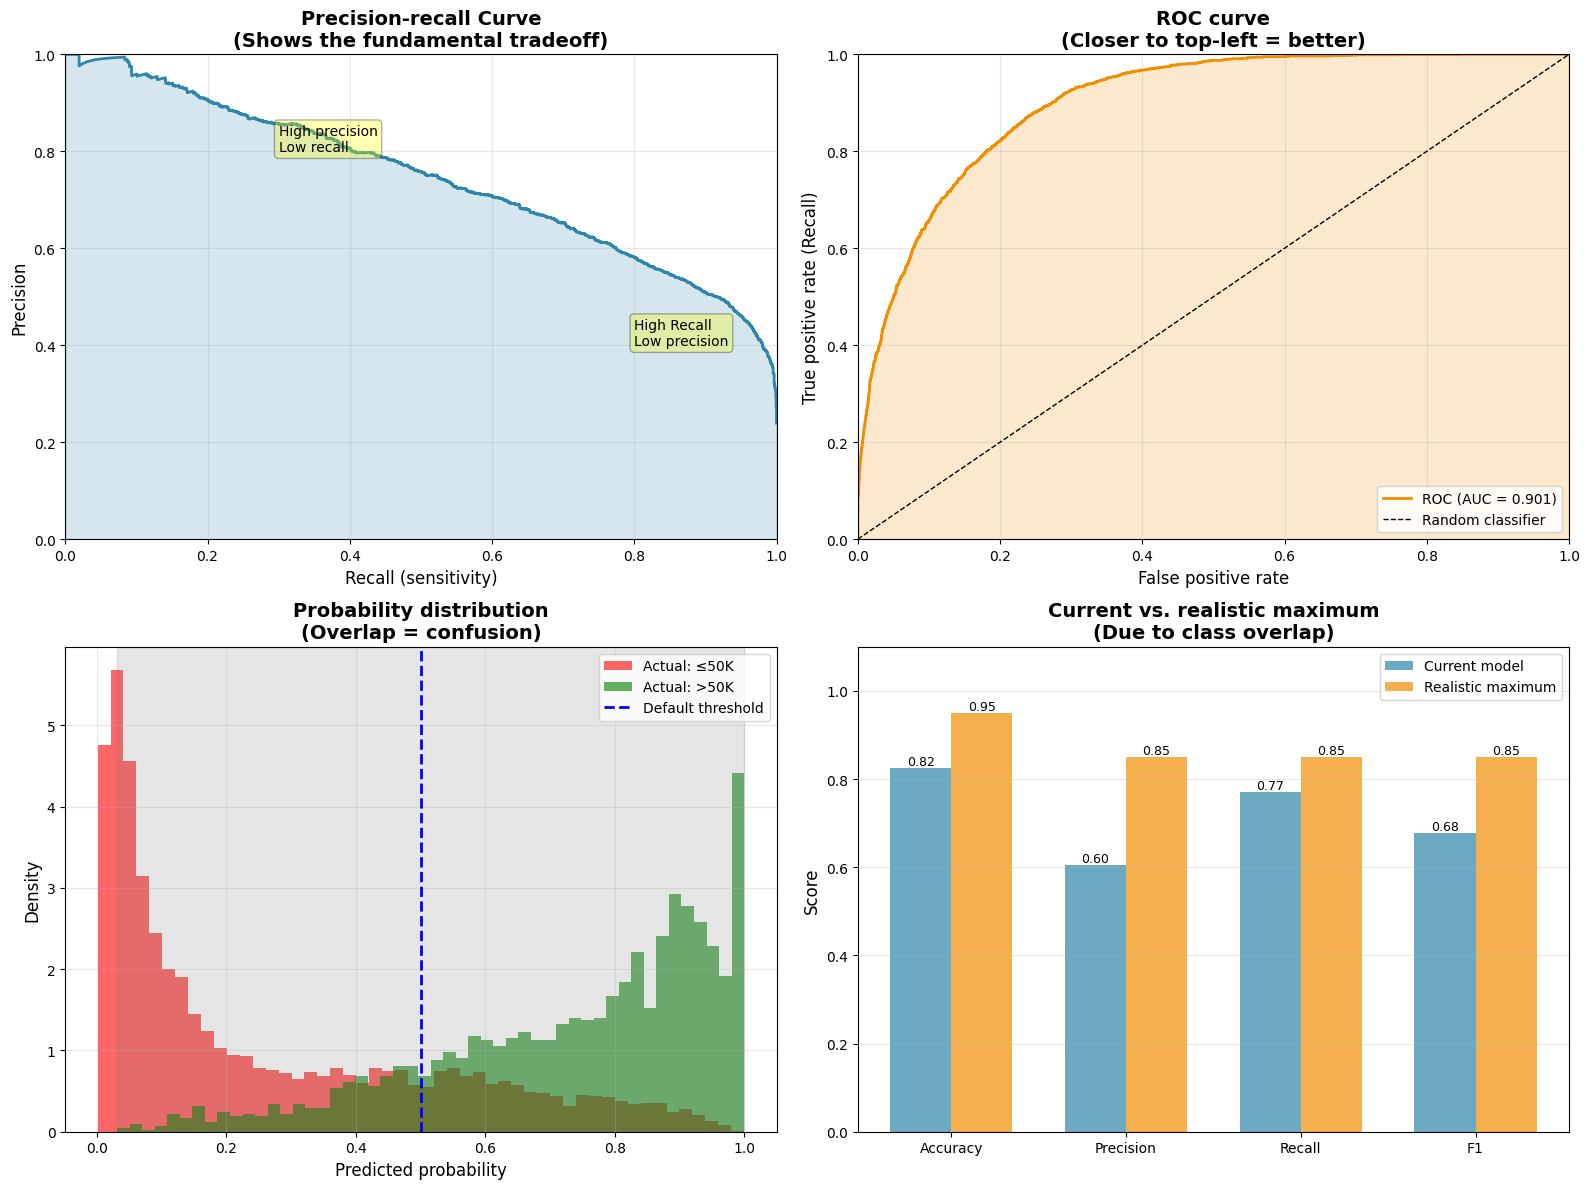

In [80]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_proba = logreg.predict_proba(X_val_processed)[:, 1]

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_val, y_proba)

fpr, tpr, roc_thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ax1.plot(recall_curve, precision_curve, linewidth=2, color='#2E86AB')
ax1.fill_between(recall_curve, precision_curve, alpha=0.2, color='#2E86AB')
ax1.set_xlabel('Recall (sensitivity)', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-recall Curve\n(Shows the fundamental tradeoff)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

ax1.annotate('High precision\nLow recall', xy=(0.3, 0.8), fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax1.annotate('High Recall\nLow precision', xy=(0.8, 0.4), fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax2.plot(fpr, tpr, linewidth=2, color='#F18F01', label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#F18F01')
ax2.set_xlabel('False positive rate', fontsize=12)
ax2.set_ylabel('True positive rate (Recall)', fontsize=12)
ax2.set_title('ROC curve\n(Closer to top-left = better)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax3.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Actual: ≤50K', density=True)
ax3.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Actual: >50K', density=True)
ax3.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Default threshold')
ax3.set_xlabel('Predicted probability', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Probability distribution\n(Overlap = confusion)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

overlap_min = max(proba_class0.min(), proba_class1.min())
overlap_max = min(proba_class0.max(), proba_class1.max())
ax3.axvspan(overlap_min, overlap_max, alpha=0.2, color='gray', label='Overlap region')

metrics_analysis = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Current': [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred)
    ],
    'Theoretical Max': [0.95, 0.85, 0.85, 0.85]  # Realistic estimates
})

x = np.arange(len(metrics_analysis))
width = 0.35

bars1 = ax4.bar(x - width/2, metrics_analysis['Current'], width, 
                label='Current model', color='#2E86AB', alpha=0.7)
bars2 = ax4.bar(x + width/2, metrics_analysis['Theoretical Max'], width,
                label='Realistic maximum', color='#F18F01', alpha=0.7)

ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Current vs. realistic maximum\n(Due to class overlap)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_analysis['Metric'])
ax4.legend(fontsize=10)
ax4.set_ylim([0, 1.1])
ax4.grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

overlap_percentage = len(y_proba[(y_proba >= overlap_min) & (y_proba <= overlap_max)]) / len(y_proba) * 100

The cell above shows the fundamental tradeoffs in binary classification.

The PRC shows you cannot maximize both simultaneously and the ROC curve measures overall discriminative ability (higher is better)
The probability overlap shows why some samples are impossible to classify correctly. Current vs theoretical max demonstrates realistic performance expectations.